In [1]:
from helper_functions import *
pd.set_option('display.max_rows', 100)

prices_df = pd.read_csv('Data\\monthly_prices.gz',compression='gzip',usecols=['date','SICCD','EXCHCD','TRDSTAT','PRC','SHROUT','NCUSIP','TICKER','COMNAM','RETX','sprtrn'])
sim_scores = pd.read_csv('Data\\sim_scores.gzip',compression='gzip',skiprows=1)
sim_scores = sim_scores.drop(sim_scores.columns[0],axis=1)
gvkey2018 = pd.read_csv('Data\\gvkey2018.csv')
funda = pd.read_csv('Data\\compustat Fundamentals.gz',compression='gzip',usecols=['gvkey','datadate','tic','sic','xrdq','revtq','niq','atq','ltq','prccq','epsfxq'])
daily_prices = pd.read_csv('Data\\daily prices.gz',compression='gzip',usecols=['date','SICCD','TICKER','PRC','RETX'])
daily_prices['date'] = pd.to_datetime(daily_prices['date'],format="%Y%m%d")

In [2]:
pharam_sic_codes = ['2830','2831','2832','2833','2834','2835','2836']
pharma_prices = get_comp_list(prices_df,pharam_sic_codes,'2006-12')
d = [pharma_prices.groupby('date').get_group(date)['TICKER'].unique() for date in pharma_prices.groupby('date').groups.keys()]
comp = set.intersection(*[set(x) for x in d])
pharma_prices = pharma_prices[pharma_prices['TICKER'].isin(comp)]
grpby_date = pharma_prices[pharma_prices['date']>'2006-11-01'].groupby('date')
mark_cap = pd.concat([grpby_date.get_group(date).sort_values('MARKCAP',ascending = False)[['date','TICKER','MARKCAP']] for date in grpby_date.groups.keys() if date.month==12])
mark_cap['date'] = mark_cap['date'].apply(lambda x:x.year)
mark_cap_1 = mark_cap.rename({'date':'datadate','TICKER':'gvkey1'},axis=1)
mark_cap_2 = mark_cap.rename({'date':'datadate','TICKER':'gvkey2'},axis=1)

TypeError: descriptor 'intersection' of 'set' object needs an argument

In [3]:
print(' '.join(list(comp)))

MRK


In [36]:
funda[funda['tic'].isin(list(set(np.append(fd['gvkey1'].unique(),fd['gvkey2'].unique()))))].to_csv('fundamentals.csv')

In [37]:
filtered_sim_scores = pd.concat([sim_df(pharma_prices,gvkey2018,year,sim_scores) for year in range(2007,2018)])
filtered_sim_scores = filtered_sim_scores.rename({'year':'datadate'},axis=1)

KeyError: Period('2007-01', 'M')

In [32]:
ratios_df_1 = get_ratios(funda,list(set(np.append(fd['gvkey1'].unique(),fd['gvkey2'].unique()))),0.9,40,'gvkey1').reset_index()
ratios_df_2 = get_ratios(funda,list(set(np.append(fd['gvkey1'].unique(),fd['gvkey2'].unique()))),0.9,40,'gvkey2').reset_index()

In [38]:
ratios_df_1.to_csv('ratios_table.csv')

In [14]:
df_1 = filtered_sim_scores.merge(ratios_df_1,on=['datadate','gvkey1'],how='left',suffixes=["_1","_2"])
df_2 = df_1.merge(ratios_df_2,on=['datadate','gvkey2'],how='left',suffixes=["_1","_2"])
df_2 = df_2[['datadate', 'gvkey1', 'real roe_1', 'roe_1','real rd_1', 'rd/rev_1','p/e_1', 'gvkey2','real roe_2', 'roe_2', 'real rd_2','rd/rev_2','p/e_2','score']]
df_3 = df_2.merge(mark_cap_1,on=['datadate','gvkey1'],how='left')
df_4 = df_3.merge(mark_cap_2,on=['datadate','gvkey2'],how='left',suffixes=['_1','_2'])
df_4 = df_4[['datadate', 'gvkey1', 'real roe_1', 'roe_1','real rd_1', 'rd/rev_1','MARKCAP_1', 'p/e_1','gvkey2','real roe_2', 'roe_2', 'real rd_2','rd/rev_2','MARKCAP_2','p/e_2','score']]
df_4['roe_spread'] = df_4['roe_1']-df_4['roe_2']
df_4['rd/rev_spread'] = df_4['rd/rev_1']-df_4['rd/rev_2']
df_4['p/e_spread'] = df_4['p/e_1']-df_4['p/e_2']
grp_boj = df_4[['datadate','gvkey1','gvkey2','score','roe_spread','rd/rev_spread','p/e_spread','MARKCAP_1','MARKCAP_2']].groupby('datadate')
df_5 = pd.concat([grp_boj.get_group(year).sort_values(['score'],ascending=False) for year in range(1997,2018)])

KeyError: 1997

In [36]:
grp_obj = daily_prices.groupby('TICKER')
prices_dict = {}
for ticker in grp_obj.groups.keys():
    for year in range(2007,2018):
        temp_df = grp_obj.get_group(ticker)
        temp_df['PRC'] = temp_df['PRC'].fillna(temp_df['PRC'].mean())
        temp_array = temp_df[temp_df['date'].dt.year==year]['PRC'].values
        prices_dict[tuple([year,ticker])] = temp_array

p_scores = []
for gvkey1,gvkey2 in [((value[0],value[1]),(value[0],value[2])) for value in df_5[['datadate','gvkey1','gvkey2']].values]:
    try:
        results = coint(prices_dict[gvkey1],prices_dict[gvkey2])
        p_scores.append((gvkey1[0],gvkey1[1],gvkey2[1],results[0],results[1]))
    except:
        None
#[key for key in prices_dict.keys() if key[0]==2009 and key[2]==252]

In [29]:
prices_df[prices_df['TICKER'].isin(set(np.append(fd['gvkey1'].unique(),fd['gvkey2'].unique())))].to_csv('monthly_prices_data.csv')

In [24]:
prices_df[prices_df['TICKER'].isin(set(np.append(fd['gvkey1'].unique(),fd['gvkey2'].unique())))][['TICKER','COMNAM']].drop_duplicates('TICKER').to_csv('company names.csv')

In [72]:
fd = pd.read_csv('final_table.csv')
' '.join(set(np.append(fd['gvkey1'].unique(),fd['gvkey2'].unique())))

'GILD IMGN PFE PDLI REGN VVUS IDXX NEOG UTHR AMGN BMRN VRTX IART ALXN TECH LLY BMY MYL MRK PRGO TEVA'

In [173]:
final_df = df_5.merge(pd.DataFrame(p_scores,columns=['datadate','gvkey1','gvkey2','t_value','p_score']),on=['datadate','gvkey1','gvkey2'],how='left')
final_df = final_df[final_df['MARKCAP_1']>10e6]
final_df = final_df[final_df['MARKCAP_2']>10e6]
final_df['abs_roe_spread'] = final_df['roe_spread'].abs()

focal_firms = pd.concat([final_df[final_df['datadate']==year][['datadate','gvkey1','gvkey2','abs_roe_spread','roe_spread']].sort_values('abs_roe_spread').head(1) for year in range(2007,2018)])

def get_focal(row):
    if row[4]<0:
        return tuple([row[0],row[2],row[1]])
    else:
        return tuple([row[0],row[1],row[2]])

focal_1 = pd.DataFrame([(pair[0],pair[1])for pair in focal_firms.apply(lambda x:get_focal(x),axis=1)],columns=['datadate','gvkey1'])
focal_2 = pd.DataFrame([(pair[0],pair[1])for pair in focal_firms.apply(lambda x:get_focal(x),axis=1)],columns=['datadate','gvkey2'])

In [107]:
final_port = focal_1.rename({'gvkey1':'Focal Long','gvkey2':'Focal Rival Short'},axis=1)
allies_ls = ['TECH','IART','IART','IART','IDXX','TECH','PRGO','REGN','REGN','PRGO','REGN']
rivals_ls = ['REGN','AMGN','BMY','LLY','BMY','IMGN','IMGN','VTRS','BMY','AMGN','TEVA'] 
final_port['allies Long'] = allies_ls
final_port['second rival Short'] = rivals_ls

In [109]:
final_port.to_csv('final_port.csv')

In [174]:
sim_scores = pd.concat([focal_1.merge(filtered_sim_scores,on=['datadate','gvkey1']),
focal_2.merge(filtered_sim_scores,on=['datadate','gvkey2'])])

allies = pd.concat([sim_scores.groupby('datadate').get_group(year).sort_values('score').head(5) for year in range(2007,2018)])
rivals = pd.concat([sim_scores.groupby('datadate').get_group(year).sort_values('score',ascending=False).head(5) for year in range(2007,2018)])

#ROE Spread
Focal Long- GILD    Allie_Long-PFE
Rival_1 Short-MRK   Rival_2 Short-BMY

#RD/Revenue Spread
Focal Long- MRK    Allie_Long-LLY
Rival_1 Short-PFE   Rival_2 Short-GILD

#p_score
Focal Long- GILD    Allie_Long-PFE
Rival_1 Short-AMGN   Rival_2 Short-BMY

#Sim score
Focal Long- LLY    Allie_Long-PRGO
Rival_1 Short-BMY   Rival_2 Short-PFE

In [39]:
import pandas as pd

final_port = pd.read_csv('final_port.csv').drop('Unnamed: 0',axis=1)
final_port = final_port.replace({'MYL':'VTRS'})

In [40]:
import bt
import matplotlib.pyplot as plt

def get_weights_dict(w1,w2,w3,w4):
    return [(array[0],list(array[1:5]),"{}={},{}={},{}={},{}={}".format(array[1],w1,array[2],w2,array[3],w3,array[4],w4)) for array in final_port.values]

In [41]:
for year,tic,weighs in get_weights_dict(0.55,-0.05,0.55,-0.05):
    print("prices_{year} = bt.data.get({tick},start='{year}-01-01', clean_tickers=False)\nstrat_{year} = bt.Strategy('{year}_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified({weighs}),bt.algos.Rebalance()])\nbt_strat_{year} = bt.Backtest(strat_{year},prices_{year}[:'{year}-12-31'])\n".format(**dict(year=year,tick=tic,weighs=weighs)))

prices_2007 = bt.data.get(['AMGN', 'PFE', 'TECH', 'REGN'],start='2007-01-01', clean_tickers=False)
strat_2007 = bt.Strategy('2007_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(AMGN=0.55,PFE=-0.05,TECH=0.55,REGN=-0.05),bt.algos.Rebalance()])
bt_strat_2007 = bt.Backtest(strat_2007,prices_2007[:'2007-12-31'])

prices_2008 = bt.data.get(['GILD', 'BMY', 'IART', 'AMGN'],start='2008-01-01', clean_tickers=False)
strat_2008 = bt.Strategy('2008_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(GILD=0.55,BMY=-0.05,IART=0.55,AMGN=-0.05),bt.algos.Rebalance()])
bt_strat_2008 = bt.Backtest(strat_2008,prices_2008[:'2008-12-31'])

prices_2009 = bt.data.get(['MRK', 'LLY', 'IART', 'BMY'],start='2009-01-01', clean_tickers=False)
strat_2009 = bt.Strategy('2009_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(MRK=0.55,LLY=-0.05,IART=0.55,BMY=-0.05),bt.algos.Rebalance()])
bt_strat_2009 = bt.Backtest(strat_2009,prices_

In [42]:
prices_2007 = bt.data.get(['AMGN', 'PFE', 'TECH', 'REGN'],start='2007-01-01', clean_tickers=False)
strat_2007 = bt.Strategy('2007_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(AMGN=0.55,PFE=-0.05,TECH=0.55,REGN=-0.05),bt.algos.Rebalance()])
bt_strat_2007 = bt.Backtest(strat_2007,prices_2007[:'2007-12-31'])

prices_2008 = bt.data.get(['GILD', 'BMY', 'IART', 'AMGN'],start='2008-01-01', clean_tickers=False)
strat_2008 = bt.Strategy('2008_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(GILD=0.55,BMY=-0.05,IART=0.55,AMGN=-0.05),bt.algos.Rebalance()])
bt_strat_2008 = bt.Backtest(strat_2008,prices_2008[:'2008-12-31'])

prices_2009 = bt.data.get(['MRK', 'LLY', 'IART', 'BMY'],start='2009-01-01', clean_tickers=False)
strat_2009 = bt.Strategy('2009_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(MRK=0.55,LLY=-0.05,IART=0.55,BMY=-0.05),bt.algos.Rebalance()])
bt_strat_2009 = bt.Backtest(strat_2009,prices_2009[:'2009-12-31'])

prices_2010 = bt.data.get(['BMY', 'PFE', 'IART', 'LLY'],start='2010-01-01', clean_tickers=False)
strat_2010 = bt.Strategy('2010_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(BMY=0.55,PFE=-0.05,IART=0.55,LLY=-0.05),bt.algos.Rebalance()])
bt_strat_2010 = bt.Backtest(strat_2010,prices_2010[:'2010-12-31'])

prices_2011 = bt.data.get(['AMGN', 'ALXN', 'IDXX', 'BMY'],start='2011-01-01', clean_tickers=False)
strat_2011 = bt.Strategy('2011_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(AMGN=0.55,ALXN=-0.05,IDXX=0.55,BMY=-0.05),bt.algos.Rebalance()])
bt_strat_2011 = bt.Backtest(strat_2011,prices_2011[:'2011-12-31'])

prices_2012 = bt.data.get(['AMGN', 'ALXN', 'TECH', 'IMGN'],start='2012-01-01', clean_tickers=False)
strat_2012 = bt.Strategy('2012_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(AMGN=0.55,ALXN=-0.05,TECH=0.55,IMGN=-0.05),bt.algos.Rebalance()])
bt_strat_2012 = bt.Backtest(strat_2012,prices_2012[:'2012-12-31'])

prices_2013 = bt.data.get(['AMGN', 'BMY', 'PRGO', 'IMGN'],start='2013-01-01', clean_tickers=False)
strat_2013 = bt.Strategy('2013_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(AMGN=0.55,BMY=-0.05,PRGO=0.55,IMGN=-0.05),bt.algos.Rebalance()])
bt_strat_2013 = bt.Backtest(strat_2013,prices_2013[:'2013-12-31'])

prices_2014 = bt.data.get(['PRGO', 'BMY', 'REGN', 'VTRS'],start='2014-01-01', clean_tickers=False)
strat_2014 = bt.Strategy('2014_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(PRGO=0.55,BMY=-0.05,REGN=0.55,VTRS=-0.05),bt.algos.Rebalance()])
bt_strat_2014 = bt.Backtest(strat_2014,prices_2014[:'2014-12-31'])

prices_2015 = bt.data.get(['VTRS', 'BMRN', 'REGN', 'BMY'],start='2015-01-01', clean_tickers=False)
strat_2015 = bt.Strategy('2015_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(VTRS=0.55,BMRN=-0.05,REGN=0.55,BMY=-0.05),bt.algos.Rebalance()])
bt_strat_2015 = bt.Backtest(strat_2015,prices_2015[:'2015-12-31'])

prices_2016 = bt.data.get(['REGN', 'BMY', 'PRGO', 'AMGN'],start='2016-01-01', clean_tickers=False)
strat_2016 = bt.Strategy('2016_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(REGN=0.55,BMY=-0.05,PRGO=0.55,AMGN=-0.05),bt.algos.Rebalance()])
bt_strat_2016 = bt.Backtest(strat_2016,prices_2016[:'2016-12-31'])

prices_2017 = bt.data.get(['VTRS', 'PRGO', 'REGN', 'TEVA'],start='2017-01-01', clean_tickers=False)
strat_2017 = bt.Strategy('2017_Port',algos = [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighSpecified(VTRS=0.55,PRGO=-0.05,REGN=0.55,TEVA=-0.05),bt.algos.Rebalance()])
bt_strat_2017 = bt.Backtest(strat_2017,prices_2017[:'2017-12-31'])

In [5]:
for year in range(2007,2018):print('report_{} = bt.run(bt_strat_{})'.format(year,year))

report_2007 = bt.run(bt_strat_2007)
report_2008 = bt.run(bt_strat_2008)
report_2009 = bt.run(bt_strat_2009)
report_2010 = bt.run(bt_strat_2010)
report_2011 = bt.run(bt_strat_2011)
report_2012 = bt.run(bt_strat_2012)
report_2013 = bt.run(bt_strat_2013)
report_2014 = bt.run(bt_strat_2014)
report_2015 = bt.run(bt_strat_2015)
report_2016 = bt.run(bt_strat_2016)
report_2017 = bt.run(bt_strat_2017)


In [43]:
report_2007 = bt.run(bt_strat_2007)
report_2008 = bt.run(bt_strat_2008)
report_2009 = bt.run(bt_strat_2009)
report_2010 = bt.run(bt_strat_2010)
report_2011 = bt.run(bt_strat_2011)
report_2012 = bt.run(bt_strat_2012)
report_2013 = bt.run(bt_strat_2013)
report_2014 = bt.run(bt_strat_2014)
report_2015 = bt.run(bt_strat_2015)
report_2016 = bt.run(bt_strat_2016)
report_2017 = bt.run(bt_strat_2017)

2007_Port
0% [############################# ] 100% | ETA: 00:00:002008_Port
0% [############################# ] 100% | ETA: 00:00:002009_Port
0% [############################# ] 100% | ETA: 00:00:002010_Port
0% [############################# ] 100% | ETA: 00:00:002011_Port
0% [############################# ] 100% | ETA: 00:00:002012_Port
0% [############################# ] 100% | ETA: 00:00:002013_Port
0% [############################# ] 100% | ETA: 00:00:002014_Port
0% [############################# ] 100% | ETA: 00:00:002015_Port
0% [############################# ] 100% | ETA: 00:00:002016_Port
0% [############################# ] 100% | ETA: 00:00:002017_Port
0% [############################# ] 100% | ETA: 00:00:00

In [66]:
for year in range(2007,2018):print('report_{}.stats,'.format(year))
pd.concat([report_2007.stats,
report_2008.stats,
report_2009.stats,
report_2010.stats,
report_2011.stats,
report_2012.stats,
report_2013.stats,
report_2014.stats,
report_2015.stats,
report_2016.stats,
report_2017.stats],axis=1).dropna().to_csv('backtest results1.csv')

report_2007.stats,
report_2008.stats,
report_2009.stats,
report_2010.stats,
report_2011.stats,
report_2012.stats,
report_2013.stats,
report_2014.stats,
report_2015.stats,
report_2016.stats,
report_2017.stats,


In [67]:
pd.set_option('display.max_rows', 500)
for year in range(2007,2018):print('bt_strat_{}.turnover.iloc[1],'.format(year))

bt_strat_2007.turnover.iloc[1],
bt_strat_2008.turnover.iloc[1],
bt_strat_2009.turnover.iloc[1],
bt_strat_2010.turnover.iloc[1],
bt_strat_2011.turnover.iloc[1],
bt_strat_2012.turnover.iloc[1],
bt_strat_2013.turnover.iloc[1],
bt_strat_2014.turnover.iloc[1],
bt_strat_2015.turnover.iloc[1],
bt_strat_2016.turnover.iloc[1],
bt_strat_2017.turnover.iloc[1],


In [70]:
pd.DataFrame([bt_strat_2007.turnover.iloc[1],
bt_strat_2008.turnover.iloc[1],
bt_strat_2009.turnover.iloc[1],
bt_strat_2010.turnover.iloc[1],
bt_strat_2011.turnover.iloc[1],
bt_strat_2012.turnover.iloc[1],
bt_strat_2013.turnover.iloc[1],
bt_strat_2014.turnover.iloc[1],
bt_strat_2015.turnover.iloc[1],
bt_strat_2016.turnover.iloc[1],
bt_strat_2017.turnover.iloc[1]]).to_csv('turnover.csv')

ROE Spread
0% [############################# ] 100% | ETA: 00:00:00RD/Revenu Spread
0% [############################# ] 100% | ETA: 00:00:00P-Score
0% [############################# ] 100% | ETA: 00:00:00sim-score
0% [############################# ] 100% | ETA: 00:00:00

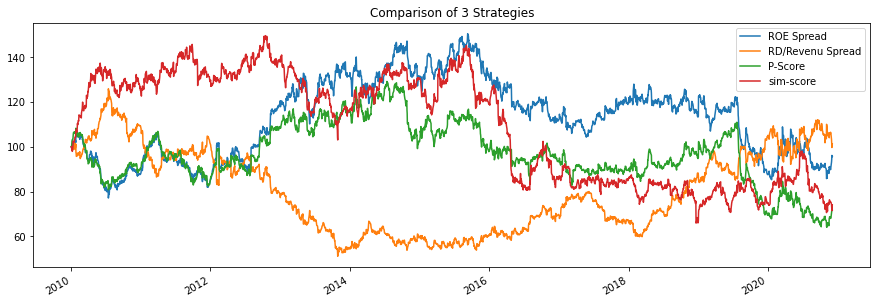

In [98]:


#prices_2 = bt.data.get(['GILD','PFE','MRK','LLY'],start='2010-01-01', clean_tickers=False)
#strat_2 = bt.Strategy("RD/Revenu Spread",algos = [bt.algos.RunQuarterly(),bt.algos.SelectAll(),bt.algos.WeighSpecified(MRK=0.5,LLY=0.5,PFE=-0.5,GILD=-0.5),bt.algos.Rebalance()])

prices_3 = bt.data.get(['GILD','PFE','AMGN','BMY'],start='2010-01-01', clean_tickers=False)
strat_3 = bt.Strategy("P-Score",algos = [bt.algos.RunQuarterly(),bt.algos.SelectAll(),bt.algos.WeighSpecified({GILD=0.5,PFE=0.5,AMGN=-0.5,BMY:-0.5}),bt.algos.Rebalance()])

prices_4 = bt.data.get(['LLY','PRGO','PFE','BMY'],start='2010-01-01', clean_tickers=False)
strat_4 = bt.Strategy("sim-score",algos = [bt.algos.RunMonthly(),bt.algos.SelectAll(),bt.algos.WeighSpecified(LLY=0.5,PRGO=0.5,PFE=-0.5,BMY=-0.5),bt.algos.Rebalance()])

bt_strat_1 = bt.Backtest(strat_1,prices_1)
bt_strat_2 = bt.Backtest(strat_2,prices_2)
bt_strat_3 = bt.Backtest(strat_3,prices_3)
bt_strat_4 = bt.Backtest(strat_4,prices_4)

report = bt.run(bt_strat_1,bt_strat_2,bt_strat_3,bt_strat_4)
report.plot()
plt.title("Comparison of 3 Strategies")
plt.show()

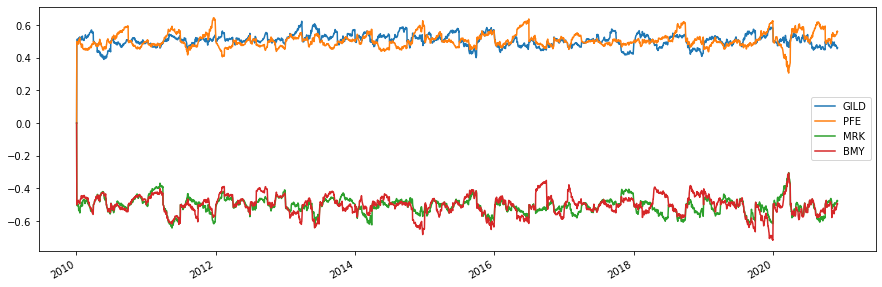

In [99]:
report.plot_security_weights()

In [69]:
def daily_prices(tick_list,year,apikey):
    combined_df = []
    for tick in tick_list:
        url = 'https://fmpcloud.io/api/v3/historical-price-full/'+tick+'?from='+str(year)+'-01-01&to='+str(year)+'-12-31&apikey='+apikey
        s = requests.get(url).content
        prices = pd.read_json(io.StringIO(s.decode('utf-8')))
        prices = pd.DataFrame(list(prices['historical'].values))
        prices.insert(0,'Tick',tick)
        combined_df.append(prices)
    combined_df = pd.concat(combined_df)
    grp_combined = combined_df[['Tick','date','adjClose']].groupby('Tick')#.keys()
    
    keys = list(grp_combined.groups.keys())
    n = len(keys)
    score_matrix = np.zeros((n,n))
    p_matrix = np.zeros((n,n))
    scores = []
    pvalues = []
    count = 0
    for i in range(n):
        for j in range(i+1,n):
            S1 = grp_combined.get_group(keys[i]).sort_values(by='date')['adjClose']
            S2 = grp_combined.get_group(keys[j]).sort_values(by='date')['adjClose']
            result = coint(S1,S2)
            scores.append((keys[i], keys[j],result[0]))
            pvalues.append((keys[i], keys[j],result[1]))
            count+=1
            print(str(count)+' Pairs done..!!')
    return scores,pvalues

In [84]:
pd.DataFrame(pvalues[1],columns=['gvkey1','gvkey2','coint_pvalues'])

,gvkey1,gvkey2,coint_pvalues
0,ABT,AGN,0.741119
1,ABT,BMY,0.594220
2,ABT,JNJ,0.705621
3,ABT,LLY,0.715006
4,ABT,MRK,0.545960
5,ABT,PFE,0.684367
6,ABT,PRGO,0.536096
7,AGN,BMY,0.132349
8,AGN,JNJ,0.100663
9,AGN,LLY,0.730153


In [63]:
prices_df[['Tick','date','adjClose']].groupby('Tick').groups.keys()

def coint_pvalues(tick)

dict_keys(['ABT', 'AGN', 'BMY', 'JNJ', 'LLY', 'MRK', 'PFE', 'PRGO'])

In [71]:
coint = coint_pavlues(list(set(filtered_comp)),2009)

[*********************100%***********************]  8 of 8 completed

1 Failed download:
- AGN: No data found, symbol may be delisted


MissingDataError: exog contains inf or nans

apikey = ['b86e0fbbe269c65e07c6d914b958c2a1','4236aeb9edb3d547b97701ace0027d75','2bc4371fafb796c9de834fe620ec9915','42d1b9e43ea2ee4d4e5b4aa1952bc523','7dc428ab0ed3d9d17f5888043104c233','4baa7289b5d87de70aa1d998e596415a','f241b872c0f04c15d222c7eccbf669f0']

def get_ratios(tick,apikey):
    key_metrics = pd.read_csv('https://fmpcloud.io/api/v3/key-metrics/'+tick+'?datatype=csv&period=quarter&apikey='+apikey)
    ratios = pd.read_csv('https://fmpcloud.io/api/v3/ratios/'+tick+'?datatype=csv&period=quarter&apikey='+apikey)
    #enterprise_values = pd.read_csv('https://fmpcloud.io/api/v3/enterprise-values/'+tick+'?datatype=csv&period=quarter&apikey='+apikey)
    combined_ratios = pd.concat([key_metrics,ratios],axis=1)
    combined_ratios = combined_ratios.loc[:,~combined_ratios.columns.duplicated()]
    combined_ratios.insert(1,'Ticker',tick)
    return combined_ratios

ratios_df = {}
left_ticks = []
for tick in list(set(comp_jan)):
    temp_df = get_ratios(tick,apikey6)
    ratios_df[tick] = temp_df
    print(tick+' Done!!')

In [21]:
#sim_score = pd.DataFrame(zip('('+sim_df['gvkey2']+','+sim_df['gvkey1']+')',sim_df['score'].values)).sort_values(0).rename({0:'pair',1:'sim_score'},axis = 1)


In [26]:
result = pd.merge(sim_138.get_group(2009),sim_138.get_group(2010), how='left', on=['gvkey1', 'gvkey2'])
result['score'] = result.apply(lambda x:x[2] if x[3]!=None else None,axis=1)
#print(result.columns)
result = result.drop(['score_x','score_y'],axis=1)
result.pivot(index='gvkey2',columns='gvkey1',values='score').to_csv('Saved Sim Matrix\\138.csv')

In [35]:
result = pd.merge(sim_4911.get_group(2009).drop('year',axis=1),sim_4911.get_group(2010).drop('year',axis=1), how='left', on=['gvkey1', 'gvkey2'])
result['score'] = result.apply(lambda x:x[2] if x[3]!=None else None,axis=1)
#print(result.columns)
result = result.drop(['score_x','score_y'],axis=1)
result.pivot(index='gvkey2',columns='gvkey1',values='score').to_csv('Saved Sim Matrix\\4911.csv')

In [7]:
import pandas as pd
sim_scores = pd.read_csv('Data\\sim_scores.gzip',compression='gzip',skiprows=1)

In [6]:
sim_scores.drop(sim_scores.columns[0],axis=1)

,year,gvkey1,gvkey2,score
0,year,gvkey1,gvkey2,score
1,1997,1004,1154,0.0238
2,1998,1004,1154,0.0269
3,1999,1004,1154,0.0318
4,2000,1004,1154,0.0318
...,...,...,...,...
32151762,2017,318728,266257,0.0013
32151763,2016,318728,276731,0.0124
32151764,2016,318728,282189,0.0155
32151765,2016,318728,317264,0.0085
